In [1]:
import math
import random
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm

import torch.nn.init as init
from torch.nn.parameter import Parameter
from sklearn.model_selection import train_test_split
from collections import namedtuple
from multiprocessing import Pool

In [2]:
Activations = {
 'Hardtanh'   : nn.Hardtanh(),
 'Sigmoid'    : nn.Sigmoid(),
 'ReLU6'      : nn.ReLU6(),
 'Tanh'       : nn.Tanh(),
 'Tanhshrink' : nn.Tanhshrink(), 
 'Hardshrink' : nn.Hardshrink(), 
 'LeakyReLU'  : nn.LeakyReLU(), 
 'Softshrink' : nn.Softshrink(),  
 'Softsign'   : nn.Softsign(),
 'ReLU'       : nn.ReLU(),
 'PReLU'      : nn.PReLU(), 
 'Softplus'   : nn.Softplus(), 
 'ELU'        : nn.ELU(),
 'SELU'       : nn.SELU(),
 'None'       : None  
}

class MLP(nn.Module):
    def __init__(self, num_layers, in_dim, hidden_dim, out_dim, activation='relu'):
        super().__init__()
        self.num_layers = num_layers
        self.in_dim = in_dim
        self.hidden_dim = hidden_dim
        self.out_dim = out_dim
        self.activation = Activations[activation]

        nonlin = True
        if self.activation is None:
            nonlin = False

        layers = []
        for i in range(num_layers - 1):
            layers.extend(
                self._layer(
                    hidden_dim if i > 0 else in_dim,
                    hidden_dim,
                    nonlin,
                )
            )
        layers.extend(self._layer(hidden_dim, out_dim, False))

        self.model = nn.Sequential(*layers)
        
        
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.kaiming_uniform_(m.weight, a=math.sqrt(5))
                fan_in, _ = nn.init._calculate_fan_in_and_fan_out(m.weight)
                bound = 1 / math.sqrt(fan_in)
                nn.init.uniform_(m.bias, -bound, bound)

    def _layer(self, in_dim, out_dim, activation=True):
        if activation:
            return [
                nn.Linear(in_dim, out_dim),
                self.activation,
            ]
        else:
            return [
                nn.Linear(in_dim, out_dim),
            ]

    def forward(self, x):
        out = self.model(x)
        return out.squeeze(1).T

In [3]:
def pict(result):

    marks = {
     'Hardtanh'   : ['o', 'yellowgreen'],
     'Sigmoid'    : ['v', 'violet'],
     'ReLU6'      : ['^', 'cadetblue'],
     'Tanh'       : ['<', 'firebrick'],
     'Tanhshrink' : ['>', 'mediumvioletred'], 
     'Hardshrink' : ['8', 'lightslategray'], 
     'LeakyReLU'  : ['s', 'darkblue'], 
     'Softshrink' : ['p', 'green'],  
     'Softsign'   : ['*', 'red'],
     'ReLU'       : ['h', 'lightpink'],
     'PReLU'      : ['H', 'aquamarine'], 
     'Softplus'   : ['D', 'aqua'], 
     'ELU'        : ['d', 'dodgerblue'],
     'SELU'       : ['P', 'fuchsia'],
     'None'       : ['X', 'orange']
    }

    
    fig = plt.figure(num=None, figsize=(20, 10), dpi=300, facecolor='w', edgecolor='k')
    for data in sorted(result, key = lambda x: x[-3], reverse = True):
        losses, act, test = data[:-2], data[-2], data[-1]
        plt.plot(np.arange(len(losses)), losses, label = f'{act} ({test:.3f})',
                 marker = marks[act][0], ms = 2.0, c = marks[act][1],
                 alpha = np.random.uniform(0.25, 0.5), lw = 2.0)
    plt.ylabel("MAE", fontsize=18)
    plt.xlabel("Epochs", fontsize=18)
    plt.legend(fontsize=14, markerscale=4.)
    plt.show()

In [4]:
def f(par):    
    TrainSet = torch.utils.data.DataLoader(Dataset(X_train, y_train),
                                       batch_size=STATE[Func]['BATCH_SIZE'],
                                       shuffle=False)
    TestSet = torch.utils.data.DataLoader(Dataset(X_test, y_test),
                                       batch_size=1000,
                                       shuffle=False)
    
    Model = MLP(num_layers=STATE[Func]['LAYERS'],
            in_dim=2,
            hidden_dim=STATE[Func]['HIDDEN'],
            out_dim=1,
            activation=par)
    optim = torch.optim.RMSprop(Model.parameters(), lr=1e-2)
    LOSS = []
    for epoch in range(STATE[Func]['EPOCHS']):  
        epoch_mse_loss = 0.0
        epoch_mae_loss = 0.0
        for inputs, labels in TrainSet:
            outputs = Model(inputs)

            optim.zero_grad()
            loss = F.mse_loss(outputs, labels)
            mae = torch.mean(torch.abs(labels - outputs)).item()
            loss.backward()
            optim.step()

            epoch_mse_loss += loss.item() 
            epoch_mae_loss += mae 
        LOSS.append(epoch_mae_loss)
    
    mae = 0.0
    for inputs, labels in TestSet:
        outputs = Model(inputs)
        mae += torch.mean(torch.abs(labels - outputs))
        
    return LOSS + [par] + [mae.item()]

### Data Generation

In [5]:
class Dataset:
    def __init__(self, X, y):
        self.X = torch.FloatTensor(X)
        self.y = torch.FloatTensor(y)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [11]:
PROD = lambda x: np.prod(x)
ADD  = lambda x: np.sum(x)

STATE = {
    'ADD' : {
        'EPOCHS'      : 150,
        'BATCH_SIZE'  : 500,
        'LAYERS'      : 2,
        'HIDDEN'      : 1,
    },
    
    'PROD' : {
        'EPOCHS'      : 2000,
        'BATCH_SIZE'  : 50,
        'LAYERS'      : 8,
        'HIDDEN'      : 5,
    }
}


def gen_data(total = 10, dimension = 2, split = 0.2, r = [0, 1000], func = None):
    X = np.random.randint(r[0], r[1], (total, dimension))
    y = np.apply_along_axis(func, 1, X)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=split, shuffle = True)
    return X_train, X_test, y_train, y_test

### Addition

In [12]:
Func = 'ADD'
X_train, X_test, y_train, y_test = gen_data(int(1e3), 2, 0.2, [0, 1000], ADD)

In [13]:
with Pool(4) as p:
    rez = p.map(f, tqdm(list(Activations.keys()), position = 0, leave = False))

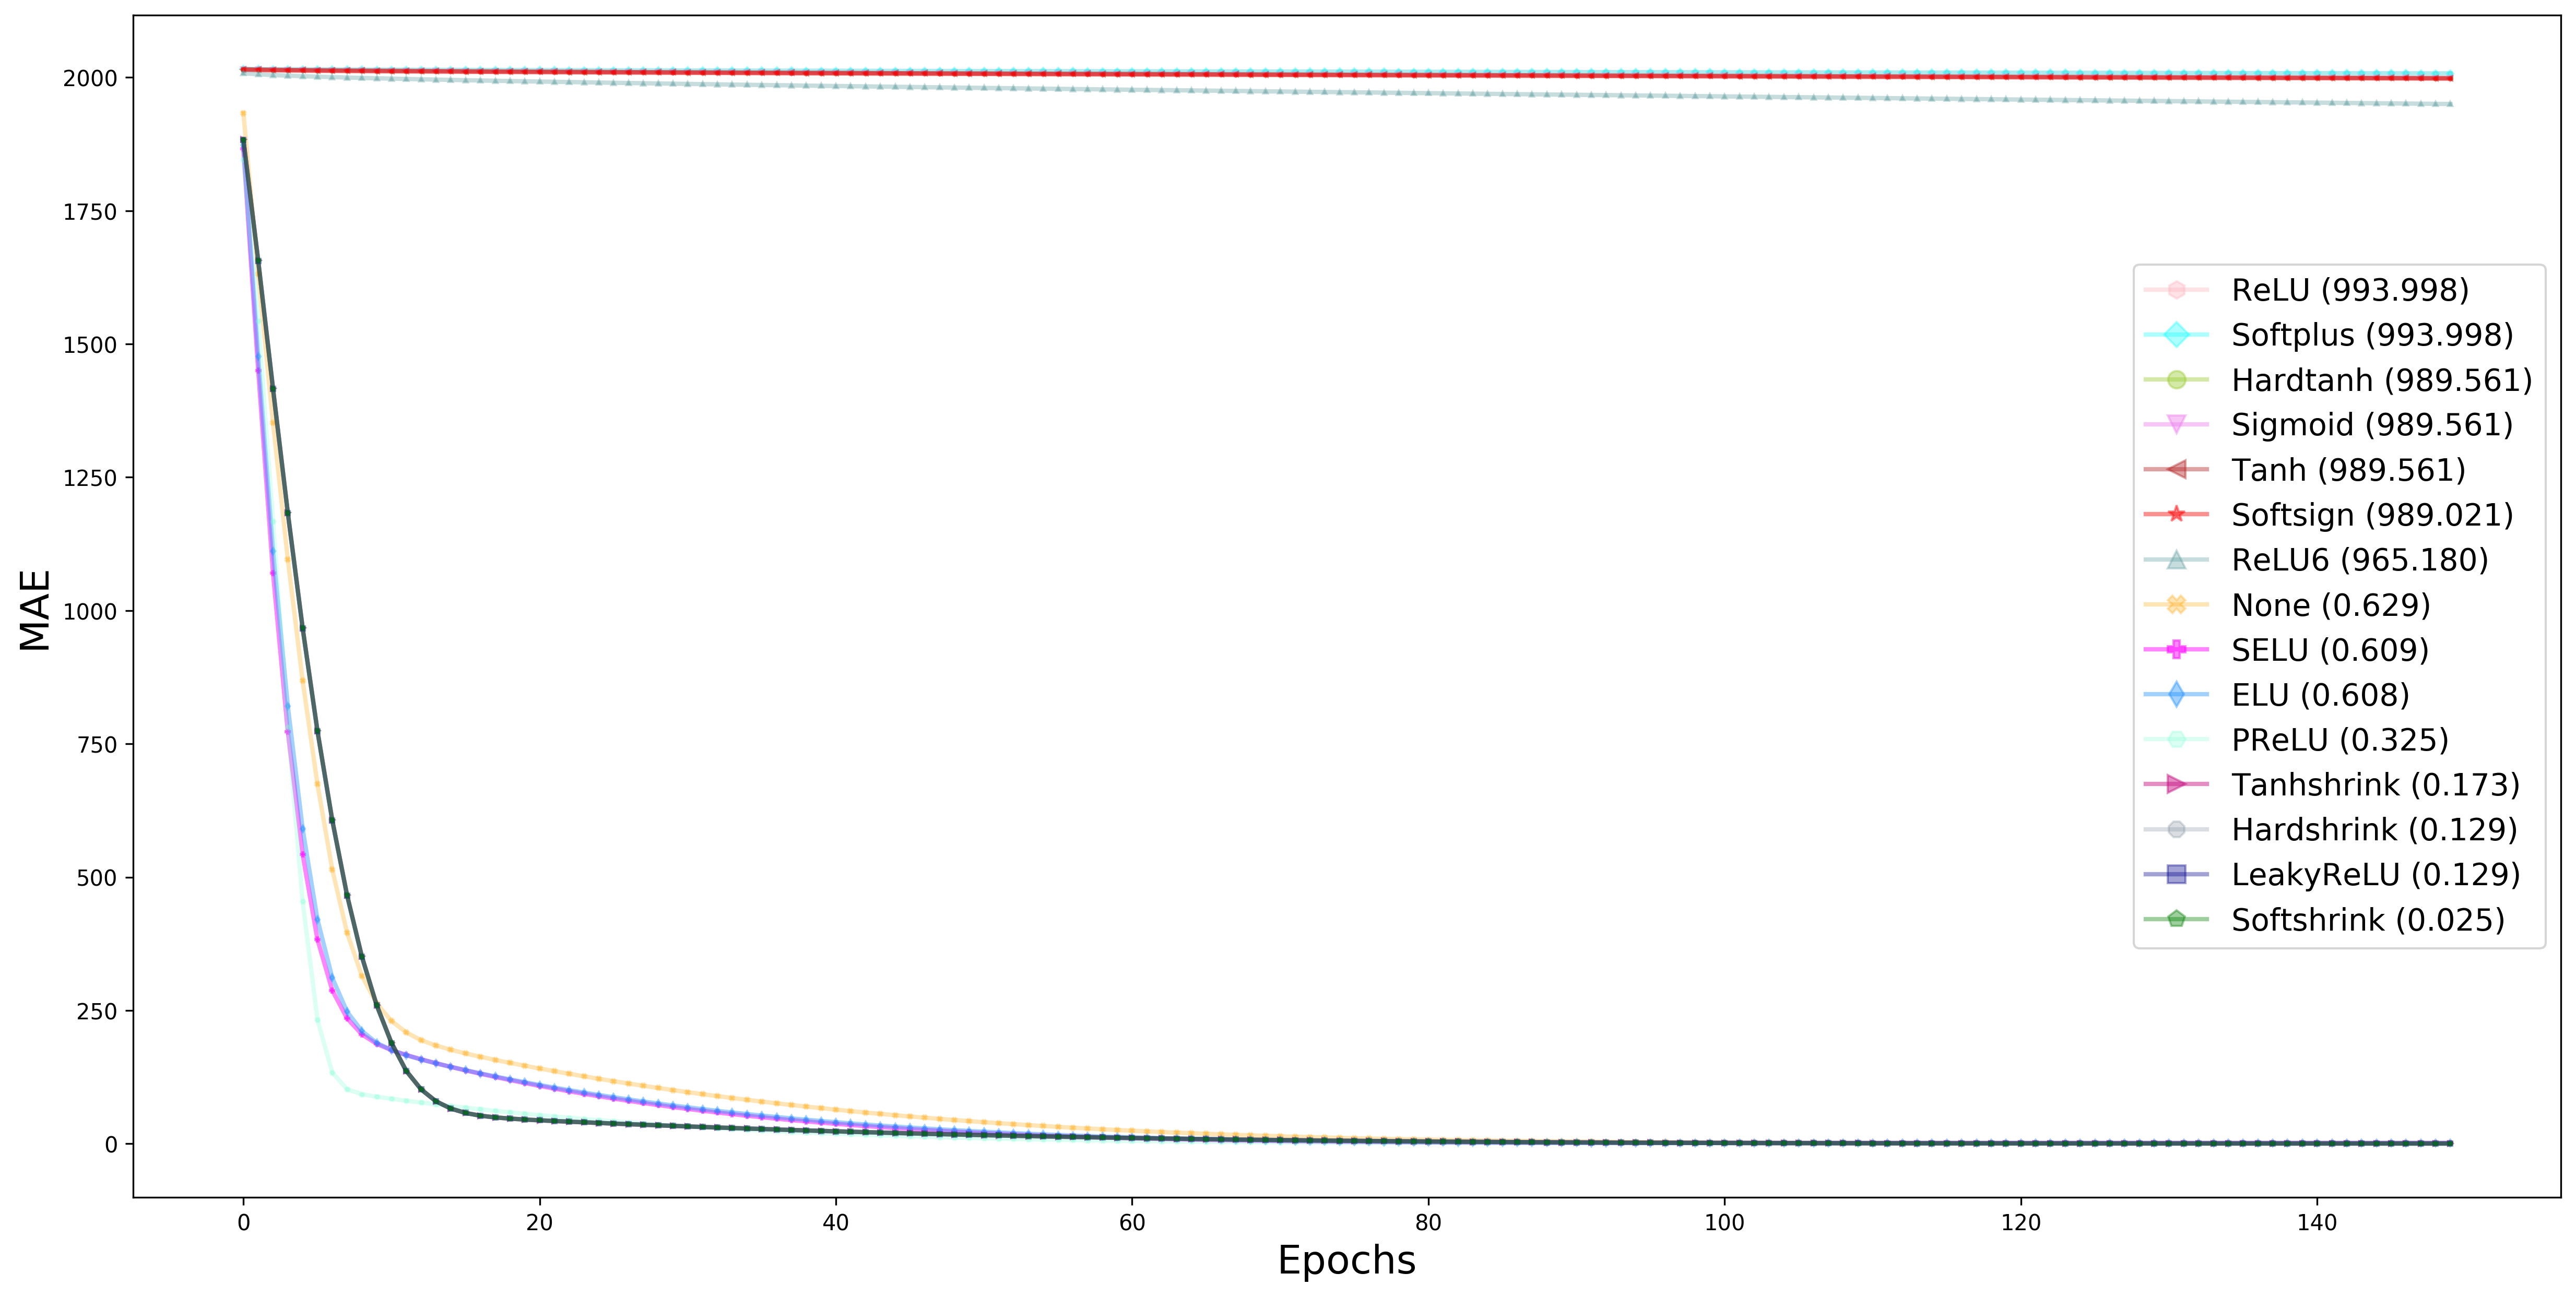

In [14]:
pict(rez)

### Multiplication

In [15]:
Func = 'PROD'
X_train, X_test, y_train, y_test = gen_data(int(1e3), 2, 0.2, [0, 1000], PROD)

In [16]:
with Pool(4) as p:
    rez = p.map(f, tqdm(list(Activations.keys()), position = 0, leave = False))

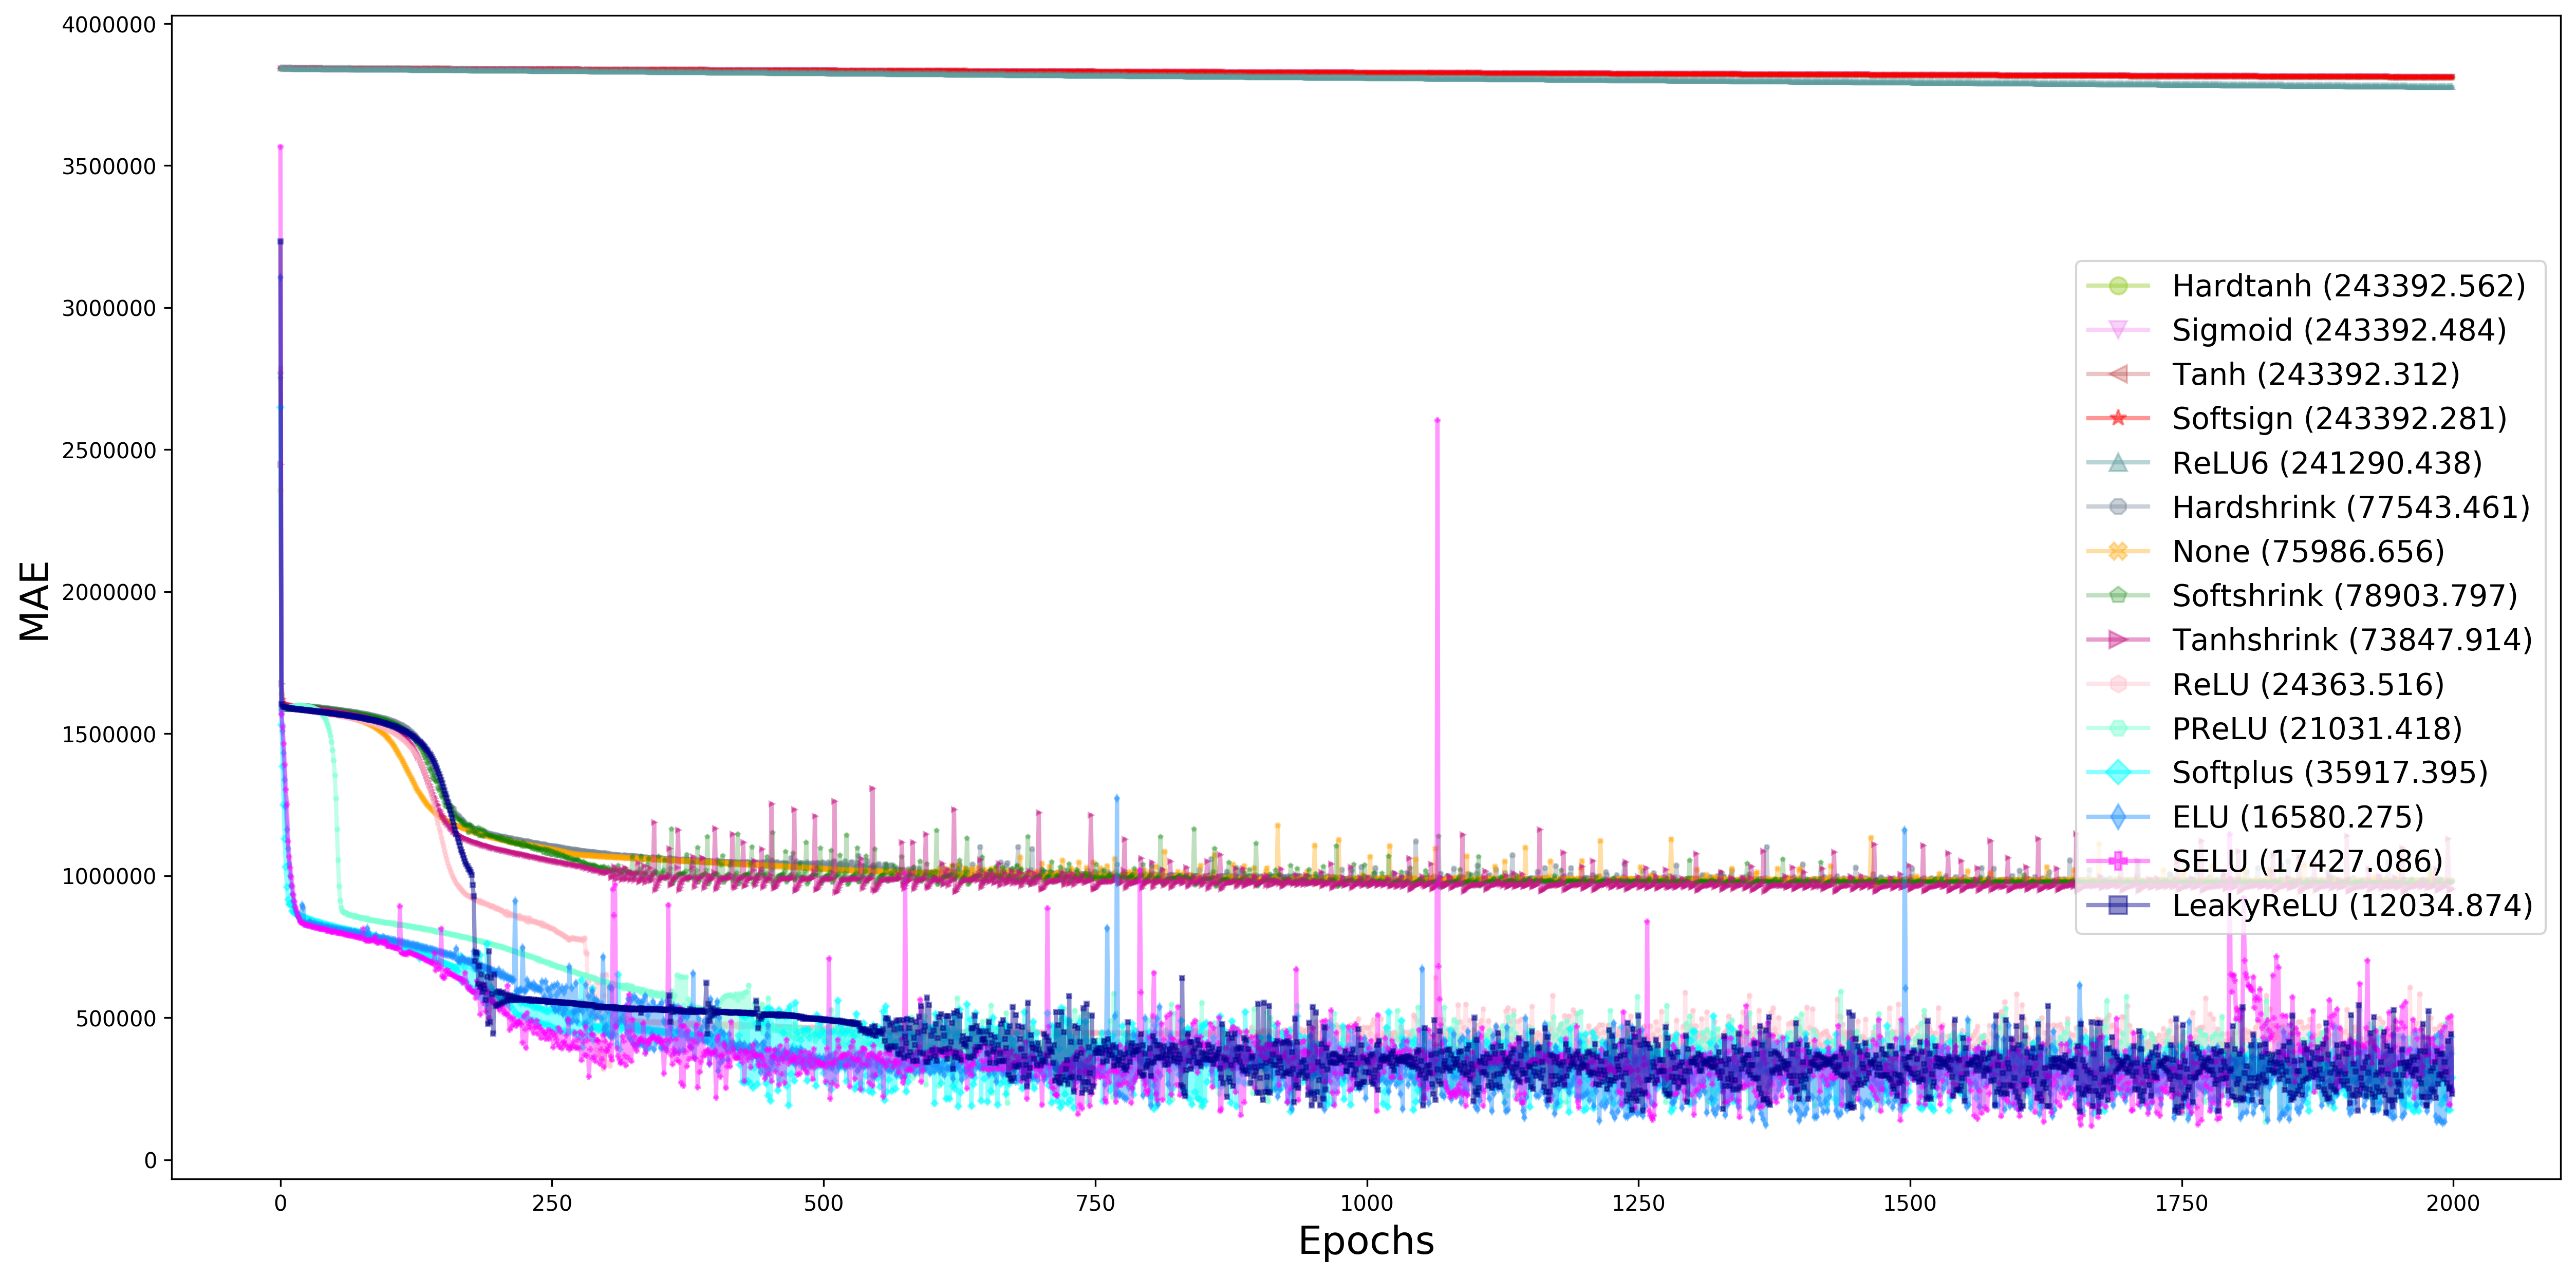

In [17]:
pict(rez)